# First Model training (aligned with baseline)

Use the same numeric features and metrics as the logistic regression baseline for apples-to-apples comparison.

## Setup and imports

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)


## Data loading and splits (stratified 60/20/20)

In [22]:
DATA_PATH = "data/grandprix_features.csv"
FEATURES = ["year", "round", "avg_race_lap_time_s", "quali_position", "prev_points_total"]
TARGET = "scored_points"

# Load and inspect
df = pd.read_csv(DATA_PATH)
print(df.head())
print("Class balance:")
print(df[TARGET].value_counts())

# Stratified splits: 60% train, 20% val, 20% test (same target as baseline)
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df[TARGET], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df[TARGET], random_state=42
)
print(f"Splits -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


   year  round               event driver          team  quali_position  \
0  2022      1  Bahrain Grand Prix    LEC       Ferrari               1   
1  2022      1  Bahrain Grand Prix    SAI       Ferrari               3   
2  2022      1  Bahrain Grand Prix    HAM      Mercedes               5   
3  2022      1  Bahrain Grand Prix    RUS      Mercedes               9   
4  2022      1  Bahrain Grand Prix    MAG  Haas F1 Team               7   

   avg_race_lap_time_s  finish_position  points_awarded  prev_points_total  \
0            97.604208              1.0            26.0                0.0   
1            98.079957              2.0            18.0                0.0   
2            98.266244              3.0            15.0                0.0   
3            98.639022              4.0            12.0                0.0   
4            98.852833              5.0            10.0                0.0   

   scored_points  
0              1  
1              1  
2              1  
3   

## Preprocessing (impute + standardize numeric)

In [23]:
# Impute simple numeric fallbacks to mirror the baseline behaviour
def impute_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["avg_race_lap_time_s"] = df["avg_race_lap_time_s"].fillna(df["avg_race_lap_time_s"].median())
    df["quali_position"] = df["quali_position"].fillna(df["quali_position"].median())
    df["prev_points_total"] = df["prev_points_total"].fillna(0.0)
    return df

train_df = impute_numeric(train_df)
val_df = impute_numeric(val_df)
test_df = impute_numeric(test_df)

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[FEATURES])
X_val = scaler.transform(val_df[FEATURES])
X_test = scaler.transform(test_df[FEATURES])

y_train = train_df[TARGET].values.astype(np.float32)
y_val = val_df[TARGET].values.astype(np.float32)
y_test = test_df[TARGET].values.astype(np.float32)

# Class weighting for imbalance (matches logistic regression class_weight="balanced")
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
pos_weight = torch.tensor(neg / pos, dtype=torch.float32)
print(f"pos_weight: {pos_weight:.3f}")


pos_weight: 1.000


## Dataset and DataLoader

In [24]:
class ArrayDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ArrayDataset(X_train, y_train)
val_ds = ArrayDataset(X_val, y_val)
test_ds = ArrayDataset(X_test, y_test)

batch_size = 32
generator = torch.Generator().manual_seed(42)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


## Model

In [25]:
input_dim = len(FEATURES)

class SimplePointsMLP(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplePointsMLP(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(f"Using device: {device}")


Using device: cuda


## Training and evaluation helpers

In [26]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_samples += y_batch.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_samples += y_batch.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def collect_predictions(model, dataloader, device):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            probs = torch.sigmoid(logits).squeeze(1)

            all_probs.append(probs.cpu())
            all_targets.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    targets = torch.cat(all_targets)
    preds = (probs >= 0.5).float()
    return targets, probs, preds


## Train loop

In [27]:
torch.manual_seed(42)
np.random.seed(42)

num_epochs = 30
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.3f}"
    )


Epoch 01 | Train Loss: 0.6850  Acc: 0.594 | Val Loss: 0.6788  Acc: 0.650
Epoch 02 | Train Loss: 0.6796  Acc: 0.661 | Val Loss: 0.6722  Acc: 0.750
Epoch 03 | Train Loss: 0.6742  Acc: 0.722 | Val Loss: 0.6653  Acc: 0.783
Epoch 04 | Train Loss: 0.6690  Acc: 0.733 | Val Loss: 0.6581  Acc: 0.750
Epoch 05 | Train Loss: 0.6629  Acc: 0.728 | Val Loss: 0.6505  Acc: 0.717
Epoch 06 | Train Loss: 0.6568  Acc: 0.733 | Val Loss: 0.6422  Acc: 0.717
Epoch 07 | Train Loss: 0.6505  Acc: 0.733 | Val Loss: 0.6332  Acc: 0.733
Epoch 08 | Train Loss: 0.6437  Acc: 0.733 | Val Loss: 0.6236  Acc: 0.733
Epoch 09 | Train Loss: 0.6358  Acc: 0.733 | Val Loss: 0.6133  Acc: 0.750
Epoch 10 | Train Loss: 0.6280  Acc: 0.733 | Val Loss: 0.6016  Acc: 0.750
Epoch 11 | Train Loss: 0.6189  Acc: 0.728 | Val Loss: 0.5895  Acc: 0.767
Epoch 12 | Train Loss: 0.6100  Acc: 0.722 | Val Loss: 0.5771  Acc: 0.767
Epoch 13 | Train Loss: 0.6008  Acc: 0.717 | Val Loss: 0.5653  Acc: 0.767
Epoch 14 | Train Loss: 0.5929  Acc: 0.728 | Val Los

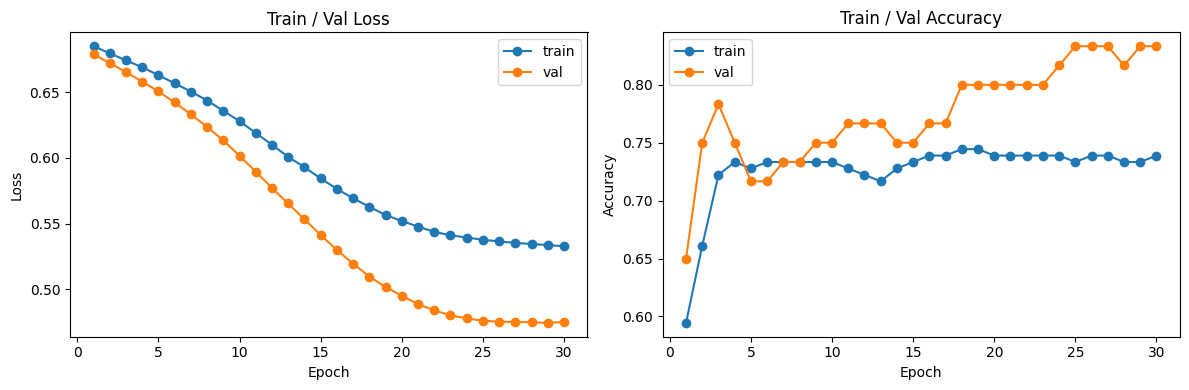

In [28]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_hist, marker="o", label="train")
plt.plot(range(1, num_epochs + 1), val_loss_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc_hist, marker="o", label="train")
plt.plot(range(1, num_epochs + 1), val_acc_hist, marker="o", label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## Test set evaluation (same metrics as baseline)

In [29]:
# Loss/accuracy
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

# Probabilities and class metrics
test_targets, test_probs, test_preds = collect_predictions(model, test_loader, device)

test_targets_np = test_targets.numpy()
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()

print(f"Test Loss: {test_loss:.4f}  Acc: {test_acc:.3f}")
print(f"Test ROC-AUC: {roc_auc_score(test_targets_np, test_probs_np):.3f}")
print(f"Test PR-AUC (avg precision): {average_precision_score(test_targets_np, test_probs_np):.3f}")

cm = confusion_matrix(test_targets_np, test_preds_np)
print("Confusion matrix:", cm)
print("Classification report:", classification_report(test_targets_np, test_preds_np, zero_division=0))


Test Loss: 0.4632  Acc: 0.767
Test ROC-AUC: 0.874
Test PR-AUC (avg precision): 0.850
Confusion matrix: [[23  7]
 [ 7 23]]
Classification report:               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        30
         1.0       0.77      0.77      0.77        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



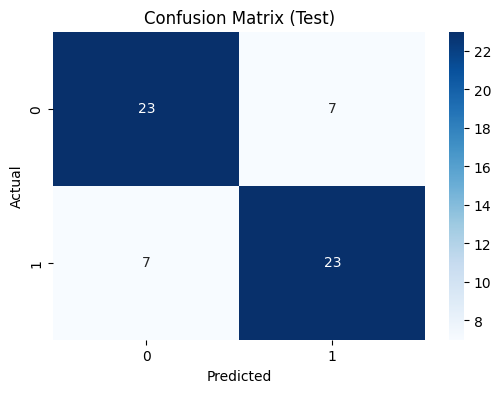

In [30]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
